In [1]:
import numpy as np
import pandas as pd

### data load

In [33]:
import numpy as np
import netCDF4 as nc
import glob

# nwp grid, stn(bias corrected) load, here example use obs data instead of bias corrected nwp
# nwp grid
#input_dir = "/Users/mankikim/JOB/DATA/"
input_dir = "D:/KMK_DATA/NWP/"
files = glob.glob(input_dir + "*.nc")
nwp_grd_u = np.array(nc.Dataset(files[-1]).variables['UGRD_10maboveground'])
nwp_grd_v = np.array(nc.Dataset(files[-1]).variables['VGRD_10maboveground'])
print("nwp_u: ", nwp_grd_u.shape)
print("nwp_v: ", nwp_grd_u.shape)


nwp_lat = np.load("../DAIO/nwp/ldaps_lat_grid")
nwp_lon = np.load("../DAIO/nwp/ldaps_lon_grid")
print(nwp_lat.shape)
print(nwp_lon.shape)

# check diff --> 4째자리부터 차이 있음
dif_lon = []
dif_lat = []
#for i in range(nwp_lon.shape[0]):
#    for j in range(nwp_lon.shape[1]-1):
for i in range(100):
    for j in range(100):
        dif_lon.append( np.round(nwp_lon[i,j+1] - nwp_lon[i,j], 3))
        dif_lat.append( np.round(nwp_lat[i+1,j] - nwp_lat[i,j], 3))
print("dif lon: ", set(dif_lon))
print("dif lat: ", set(dif_lat))

# obs stn for 불규칙 데이터
obs_stnd = np.load("../DAIO/obs/merge/obs_data")
print(obs_stnd.shape)


# select U & V
#if sel_v == 'u':
#    nwp_grid[:,:,0]

nwp_u:  (49, 781, 602)
nwp_v:  (49, 781, 602)
(781, 602)
(781, 602)
dif lon:  {0.016}
dif lat:  {0.014}
(868, 48, 2)


### make for input format

### Objective analysis(barnes)

In [7]:
flatten_input = []
for i in range(nwp_lat.shape[0]): # lat
    for j in range(nwp_lat.shape[1]): # lon
        flatten_input.append([ nwp_lat[i,j], nwp_lon[i,j], nwp_grd_u[0,i,j] ])

len(flatten_input)
input_data = np.asarray(flatten_input)
print(input_data[0])

# extract attribute 
lon_lat_data = input_data[:, 0:2]
qff_values = input_data[:, 2]

print(lon_lat_data[0][0], ',', lon_lat_data[0][1])
print(qff_values[0])



[ 32.256875   121.834429     3.23674822]
32.256875000000015 , 121.83442899999999
3.236748218536377


In [50]:
#!pip install fast-barnes-py

# definition of a 12Â° x 12Â° grid starting at 9Â°W / 47Â°N
# resolution = 32.0
# step = 1.0 / resolution
# x0 = np.asarray([-9.0, 47.0], dtype=np.float64)
# size = (int(12.0 / step), int(12.0 / step))


#resolution = 32.0
#step = 0.005
lat_dist = abs(lon_lat_data[:,0].min() - lon_lat_data[:,0].max())
lon_dist = abs(lon_lat_data[:,1].min() - lon_lat_data[:,1].max())
step_lat = lat_dist/nwp_lat.shape[0]
step_lon = lon_dist/nwp_lat.shape[1]
print(lon_lat_data[:,0].min())
print(lon_lat_data[:,0].max())
print(lon_lat_data[:,1].min())
print(lon_lat_data[:,1].max())
print("lat_dist ", np.round(lat_dist,3))
print("lon_dist ", np.round(lon_dist,3))
x0 = np.asarray([lon_lat_data[0][0], lon_lat_data[0][1]], dtype=np.float64)
size = (int(lat_dist / step_lat), int(lon_dist / step_lon))
print('step_lat: ', step_lat)
print('step_lon: ', step_lon)
print('x0: ', x0)
print("size = ", size)


# calculate Barnes interpolation
from fastbarnes import interpolation
sigma = 1.0
field = interpolation.barnes(lon_lat_data, qff_values, sigma, x0, step_lat, size)
print(type(field))
print(np.round(field, 2))

32.188086607613876
43.12964515366301
121.06029481806667
132.531874170454
lat_dist  10.942
lon_dist  11.472
step_lat:  0.014009678035914389
step_lon:  0.019055779655128443
x0:  [ 32.256875 121.834429]
size =  (781, 602)
<class 'numpy.ndarray'>
[[-4.9995001e+20 -4.9995001e+20 -4.9995001e+20 ... -4.9995001e+20
  -4.9995001e+20 -4.9995001e+20]
 [-4.9995001e+20 -4.9995001e+20 -4.9995001e+20 ... -4.9995001e+20
  -4.9995001e+20 -4.9995001e+20]
 [-4.9995001e+20 -4.9995001e+20 -4.9995001e+20 ... -4.9995001e+20
  -4.9995001e+20 -4.9995001e+20]
 ...
 [-4.9995001e+20 -4.9995001e+20 -4.9995001e+20 ... -4.4367690e+20
  -4.4362117e+20 -4.4356618e+20]
 [-4.9995001e+20 -4.9995001e+20 -4.9995001e+20 ... -4.4339581e+20
  -4.4333984e+20 -4.4328463e+20]
 [-4.9995001e+20 -4.9995001e+20 -4.9995001e+20 ... -4.4311645e+20
  -4.4306026e+20 -4.4300488e+20]]


TypeError: Length of y (385) must match number of rows in z (384)

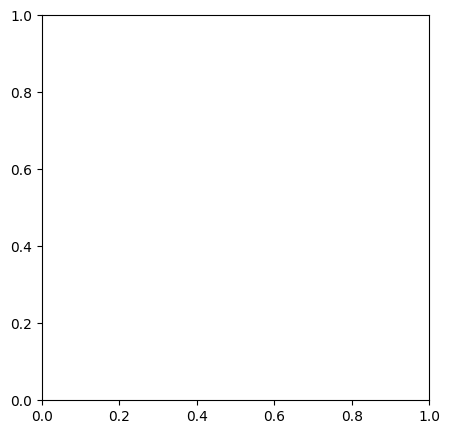

In [14]:
# draw graphic with labeled contours and scattered sample points
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))

gridX = np.arange(x0[0], x0[0]+size[1]*step, step)
gridY = np.arange(x0[1], x0[1]+size[0]*step, step)
levels = np.arange(-20, 20, 1)
cs = plt.contour(gridX, gridY, field, levels)
plt.clabel(cs, levels[::2], fmt='%d', fontsize=9)

plt.scatter(lon_lat_data[:, 0], lon_lat_data[:, 1], color='red', s=20, marker='.')

plt.show()

In [20]:
input_data = np.asarray([
    [-3.73,56.33,995.1], [2.64,47.05,1012.5], [-8.40,47.50,1011.3], [2.94,54.33,1006.0], [-2.90,49.90,1006.3],
    [-8.98,53.72,1002.1], [1.20,58.60,1002.6], [1.60,50.73,1009.1], [-7.38,57.36,997.7], [-1.25,53.01,1000.4],
    [-4.74,52.79,998.4], [-0.61,47.48,1013.0], [-6.10,50.10,1004.3], [-6.46,54.87,996.4], [-3.22,47.29,1012.8],
    [-1.60,55.42,996.6], [2.30,56.60,1004.5], [1.12,52.95,1003.6], [-0.90,57.80,999.9], [-7.90,51.40,1002.6],
    [-0.70,50.10,1007.5], [2.53,49.02,1010.8], [-5.06,48.47,1008.5], [-3.10,53.60,997.5], [-5.63,57.86,997.8],
    [-6.90,52.85,1000.9], [-4.15,51.09,1002.6], [-1.99,51.50,1002.7], [1.21,47.68,1011.7], [-5.70,56.30,995.5],
    [-1.98,53.13,998.5], [1.09,49.93,1009.0], [1.72,58.42,1002.9], [-6.30,52.30,999.4], [0.70,57.70,1001.9],
    [-3.50,53.60,995.9], [1.38,48.06,1011.6], [-4.37,51.71,1001.1], [-3.09,58.45,998.5], [2.00,56.40,1003.9],
    [1.90,57.00,1003.3], [0.45,51.90,1004.9], [-8.25,51.80,1002.5], [-1.87,53.81,997.4], [-2.38,55.71,995.1],
    [-4.01,54.80,992.1], [0.88,53.37,1002.6], [-1.69,51.86,1002.1], [-4.57,52.14,999.6], [-0.20,58.40,1001.1],
])

input_data.shape
print(input_data[:,0].min())
print(input_data[:,0].max())
print(input_data[:,0].min() - input_data[:,0].max())

-8.98
2.94
-11.92
